In [118]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/msmid/mmm_HED/')
import numpy as np
import matplotlib.pyplot as plt
import mmmUtils as mu
from importlib import reload 
import extra_mmm as em
import run_overview_lib_4446 as run_overview_lib
reload(em)

proposal=4446


In [120]:
import os
import cv2
import numpy as np
import xarray as xr
from skimage.measure import LineModelND, ransac
from skimage.draw import line_aa
from collections import deque
from matplotlib.cm import get_cmap
from pathlib import Path

#sys.path.append('/gpfs/exfel/exp/HED/202302/p004446/usr/Shared/p4446-jet/Online-data-visualization/jet-pointing/')
import metro_context_em as mc
reload(em)
reload(mc)
runNos=np.arange(29,50)
debug=0
for runNo in runNos:
    run = em.open_run(proposal, runNo, data='all')  #Opening the given run
    jet_positions=em.get_jet_positions(run,debug=0,maxtrains=150000,reload=1)


Getting jet positions
 [******************************] 969/970 Getting jet positions
 [******************************] 903/907 Getting jet positions
 [******************************] 826/834 Getting jet positions
 [******************************] 925/931 Getting jet positions
 [******************************] 1,002/1,011 Getting jet positions
 [*****************************-] 364/372 Getting jet positions
 [******************************] 683/684 Getting jet positions
 [******************************] 606/615 Getting jet positions
 [******************************] 606/614 Getting jet positions
 [******************************] 606/612 Getting jet positions
 [*****************************-] 606/617 Getting jet positions
 [******************************] 606/611 Getting jet positions
 [------------------------------]  1/1,204 

RuntimeError: Mask data shape ((1216, 1936)) does not match data ((3036, 2000))

In [114]:
print(jet_positions[:15,2])

[        nan 53.57053559         nan 95.90119968         nan 64.8506779
         nan 57.74056351         nan 43.01792937         nan 31.0220153
         nan 34.3276957          nan]


In [103]:
from matplotlib import colors

#plt.plot(jet_positions[:,1],jet_positions[:,2],'*')
ss=np.isfinite(np.sum(jet_positions,1))
#selfin=
v,x,y=np.histogram2d(jet_positions[ss,1],jet_positions[ss,2],bins=20)
plt.imshow(v,norm=colors.LogNorm())
#plt.colorbar()

ValueError: vmin must be less or equal to vmax

<Figure size 432x288 with 1 Axes>

In [73]:
reload(mc)
runNo=24
debug=0
run = em.open_run(proposal, runNo, data='all')  #Opening the given run
trains=em.get_all_trains(run)
numtrains=np.size(trains)
jet_positions=np.zeros((np.size(trains),3))*np.nan
print('Getting jet positions')
for ti,trainId in enumerate(trains):
    print(trainId)
    mu.update_progress(ti,numtrains)
    cams=['CAM1','CAM2']
    jet_positions[ti,0]=train
    for ci,cam in enumerate(cams):
        img=em.get_image(run,cam,trainId=trainId)
        print(img)
        data=xr.DataArray(img)
        jp = mc.JetPosition(cam)
        if cam=='CAM1':
            jp.reshape=False
            jp.mask_file='cam1_mask.npy'
            jp.blur_kernel=81
            jp.beam_pixel_height=666
            jp.beam_pixel_x=1010
            jp.jet_det_thresh=0.3
            jp.line_offset=5
            jp.roi_x=slice(800,1200)
            jp.um_per_pixel= 1.162

        if cam=='CAM2':
            jp.reshape=False
            jp.mask_file='cam2_mask.npy'
            jp.blur_kernel=81
            jp.beam_pixel_height=1211
            jp.beam_pixel_x=1810
            jp.jet_det_thresh=100
            jp.jet_det_thresh=0.3
            jp.line_offset=30
            jp.roi_x=slice(1300,2300)
            jp.um_per_pixel= 0.1225

        #jp.roi_x=(100,1000)

        #this is in Imager
        ds=jp.data_shape(data)
        raw=jp.raw(data)
        #background=jp.background(raw)
        background=raw*0
        mask=jp.mask(ds)
        bgs=jp.bg_subtracted(raw,mask,background)
        blur=jp.blur(bgs)
        threshold=jp.threshold(blur,mask)
        foreground=jp.foreground(bgs,threshold)

        median_foreground=jp._median_foreground(foreground)
        line_fit=jp.line_fit(median_foreground)
        perp_dist=jp.perpendicular_distance(line_fit,bgs)
        jet_absorption=jp.jet_absorption(bgs,perp_dist,mask)
        jet_present=jp.jet_present(jet_absorption)
        #jet_present=True
        jet_fit=jp.jet_fit(bgs,perp_dist,jet_present)
        jet_x=jp.jet_x(line_fit,jet_present)
        if debug:
            print(jet_x)
            mu.figure()
            plt.imshow(jet_fit.transpose())
        jet_positions[ti,ci+1]=jet_x
    if ti>10:break

Getting jet positions
1787345192
 [------------------------------]  0/2,112 Warning: Diagnotics HED_EXP_PPT/CAM/CAM_1:daqOutput has no key data.image.pixels for given train, therefore providing no data.
[]


IndexError: tuple index out of range

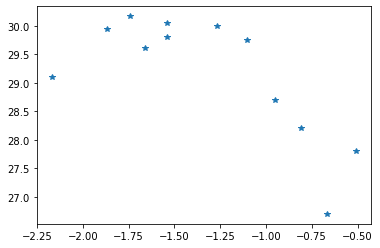

In [61]:
jet_positions
plt.plot(jet_positions[:,1],jet_positions[:,2],'*')

In [63]:
jet_present

<xarray.DataArray ()>
array(True)

In [25]:
DA.data

array([[1267, 1529, 1341, ..., 1177, 1356, 1267],
       [1430, 1315, 1274, ..., 1565, 1401, 1392],
       [1264, 1241, 1125, ..., 1316, 1471, 1279],
       ...,
       [ 665,  690,  673, ...,  549,  612,  562],
       [ 684,  721,  659, ...,  711,  648,  535],
       [ 733,  731,  577, ...,  746,  675,  585]], dtype=uint16)